In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import utils as vutils
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [2]:
# data_dir = "/home/pervinco/Datasets/cifar-10-batches-py"
# data_dir = "/home/pervinco/Datasets/CelebA"
data_dir = "/home/pervinco/Datasets/torch_mnist"
save_dir = "./runs/DCGAN"

epochs = 20
batch_size = 128
lr = 0.0002
beta1 = 0.5

image_size = 64
latent_dim = 100
input_dim = 1
ndf = 64  # 생성자의 특성 맵 크기
ngf = 64  # 판별자의 특성 맵 크기

num_workers = os.cpu_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

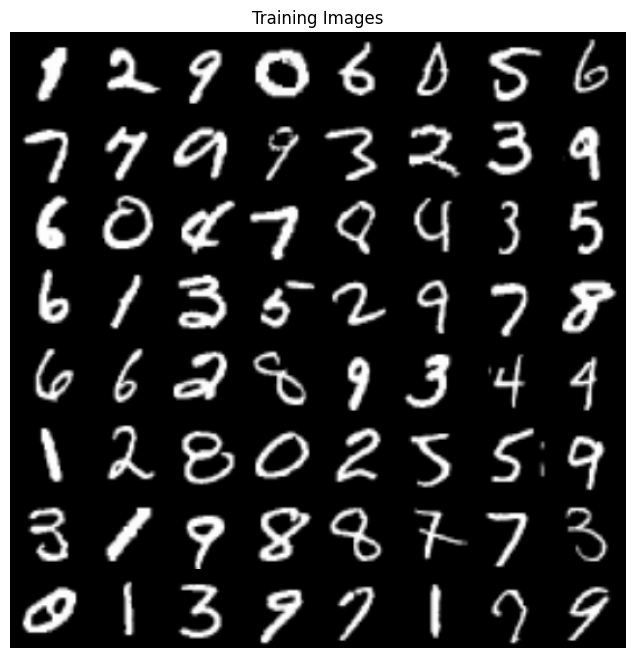

In [11]:
# ================================================================== #
#                           Data Process                             #
# ================================================================== #
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Normalize([0.5], [0.5])
])

# train_dataset = ImageFolder(root=data_dir, transform=transfomr)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

train_dataset = datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, nz, nc):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8, kernel_size=4, stride=1, padding=0, bias=False), ## latent --> (ngf*8) x 4 x 4
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False), ## (ngf*8) x 4 x 4 --> (ngf*4) x 8 x 8
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2, kernel_size=4, stride=2, padding=1, bias=False), ## (ngf*4) x 8 x 8 --> (ngf*2) x 16 x 16
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False), ## (ngf*2) x 16 x 16 --> (ngf) x 32 x 32
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=4, stride=2, padding=1, bias=False), ## (ngf) x 32 x 32 --> (nc) x 64 x 64
            nn.Tanh())

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False), ## 3 x 64 x 64 --> ndf x 32 x 32
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False), ## ndf x 32 x 32 --> (ndf * 2) x 16 x 16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False), ## (ndf * 2) x 16 x 16 --> (ndf * 4) x 8 x 8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False), ## (ndf * 4) x 8 x 8 --> (ndf*8) x 4 x 4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [6]:
def train(D, G, dataloader, d_optimizer, g_optimizer, criterion, device):
    D_losses, G_losses = [], []
    D_real_accuracies, D_fake_accuracies_before_update, D_fake_accuracies_after_update = [], [], []
    
    for idx, (images, _) in enumerate(tqdm(dataloader, desc="Train", leave=False)):
        bs = images.size(0)
        real_images = images.to(device)
        real_labels = torch.full((bs,), 1., dtype=torch.float, device=device)
        fake_labels = torch.full((bs,), 0., dtype=torch.float, device=device)

        ## first term of Object function
        D.zero_grad()
        Gx = D(real_images).view(-1) ## [128, 1, 1, 1] --> [128]
        d_real_loss = criterion(Gx, real_labels)
        d_real_loss.backward()
        D_real_accuracies.append((Gx > 0.5).float().mean().item())

        ## second term of Object function
        z = torch.randn(bs, latent_dim, 1, 1, device=device) ## [batch_size, 100, 1, 1]
        Gz = G(z) ## fake images [batch_size, 3, 64, 64]

        ## detach : 생성자 G의 출력에서 계산된 그래디언트가 생성자 자체로 역전파되는 것을 방지함.
        DGz1 = D(Gz.detach()).view(-1) ## [128, 1, 1, 1] --> [128]
        d_fake_loss = criterion(DGz1, fake_labels) 
        d_fake_loss.backward()
        D_fake_accuracies_before_update.append((DGz1 < 0.5).float().mean().item())

        d_loss = d_real_loss + d_fake_loss
        d_optimizer.step()

        ## Train Generator
        G.zero_grad()
        DGz2 = D(Gz).view(-1) ## [128, 1, 1, 1] --> [128]
        g_loss = criterion(DGz2, real_labels)
        g_loss.backward()
        D_fake_accuracies_after_update.append((DGz2 > 0.5).float().mean().item())
        g_optimizer.step()

        D_losses.append(d_loss.item())
        G_losses.append(g_loss.item())

    avg_metrics = {
        'D_loss': sum(D_losses) / len(D_losses),
        'G_loss': sum(G_losses) / len(G_losses),
        'D_real_acc': sum(D_real_accuracies) / len(D_real_accuracies),
        'D_fake_acc_before': sum(D_fake_accuracies_before_update) / len(D_fake_accuracies_before_update),
        'D_fake_acc_after': sum(D_fake_accuracies_after_update) / len(D_fake_accuracies_after_update),
    }
    return avg_metrics

In [ ]:
def save_fake_images(epoch, G, fixed_noise, num_images=64):
    with torch.no_grad():  # 그래디언트 계산을 하지 않음
        fake_images = G(fixed_noise).detach().cpu()
    fig = plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Fake Images at Epoch {epoch}")
    plt.imshow(np.transpose(vutils.make_grid(fake_images[:num_images], padding=2, normalize=True), (1, 2, 0)))
    plt.savefig(f"{save_dir}/Epoch_{epoch}_Fake.png")  # 이미지 파일로 저장
    plt.close(fig)

In [7]:
# ================================================================== #
#                    Model, Optimizer, Cost func                     #
# ================================================================== #
D = Discriminator(input_dim).to(device)
G = Generator(latent_dim, input_dim).to(device)
D.apply(weights_init)
G.apply(weights_init)

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))


# ================================================================== #
#                       Training Iterations                          #
# ================================================================== #
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
for epoch in range(epochs):
    print(f"Epoch [{epoch+1}/{epochs}]")
    metrics = train(D, G, train_dataloader, d_optimizer, g_optimizer, criterion, device)
    print(f'Discriminator Loss: {metrics["D_loss"]:.4f}')
    print(f'Generator Loss: {metrics["G_loss"]:.4f}')
    print(f'Discriminator Real Accuracy: {metrics["D_real_acc"]:.4f}')
    print(f'Discriminator Fake Accuracy (Before G Update): {metrics["D_fake_acc_before"]:.4f}')
    print(f'Discriminator Fake Accuracy (After G Update): {metrics["D_fake_acc_after"]:.4f}') ##  판별자가 가짜 이미지를 "진짜"로 잘못 분류한 점수.

    save_fake_images(epoch+1, G, fixed_noise)

# Save the model checkpoints 
torch.save(G.state_dict(), f'{save_dir}/G.ckpt')
torch.save(D.state_dict(), f'{save_dir}/D.ckpt')

Epoch [1/20]


Discriminator Loss: 0.5274
Generator Loss: 5.8944
Discriminator Real Accuracy: 0.9426
Discriminator Fake Accuracy (Before G Update): 0.9471
Discriminator Fake Accuracy (After G Update): 0.0150
Epoch [2/20]


Discriminator Loss: 0.6098
Generator Loss: 2.6424
Discriminator Real Accuracy: 0.9019
Discriminator Fake Accuracy (Before G Update): 0.9086
Discriminator Fake Accuracy (After G Update): 0.0647
Epoch [3/20]


Discriminator Loss: 0.6248
Generator Loss: 2.5911
Discriminator Real Accuracy: 0.8980
Discriminator Fake Accuracy (Before G Update): 0.9011
Discriminator Fake Accuracy (After G Update): 0.0641
Epoch [4/20]


Discriminator Loss: 0.5585
Generator Loss: 3.2695
Discriminator Real Accuracy: 0.9009
Discriminator Fake Accuracy (Before G Update): 0.9058
Discriminator Fake Accuracy (After G Update): 0.0493
Epoch [5/20]


Discriminator Loss: 0.4862
Generator Loss: 3.3630
Discriminator Real Accuracy: 0.9147
Discriminator Fake Accuracy (Before G Update): 0.9190
Discriminator Fake Accuracy (After G Update): 0.0355
Epoch [6/20]


Discriminator Loss: 0.5011
Generator Loss: 3.4448
Discriminator Real Accuracy: 0.9062
Discriminator Fake Accuracy (Before G Update): 0.9131
Discriminator Fake Accuracy (After G Update): 0.0441
Epoch [7/20]


Discriminator Loss: 0.4562
Generator Loss: 3.3806
Discriminator Real Accuracy: 0.9187
Discriminator Fake Accuracy (Before G Update): 0.9229
Discriminator Fake Accuracy (After G Update): 0.0423
Epoch [8/20]


Discriminator Loss: 0.4473
Generator Loss: 3.5516
Discriminator Real Accuracy: 0.9203
Discriminator Fake Accuracy (Before G Update): 0.9246
Discriminator Fake Accuracy (After G Update): 0.0356
Epoch [9/20]


Discriminator Loss: 0.4538
Generator Loss: 3.4849
Discriminator Real Accuracy: 0.9217
Discriminator Fake Accuracy (Before G Update): 0.9260
Discriminator Fake Accuracy (After G Update): 0.0366
Epoch [10/20]


Discriminator Loss: 0.4474
Generator Loss: 3.4920
Discriminator Real Accuracy: 0.9224
Discriminator Fake Accuracy (Before G Update): 0.9238
Discriminator Fake Accuracy (After G Update): 0.0473
Epoch [11/20]


Discriminator Loss: 0.5092
Generator Loss: 3.4546
Discriminator Real Accuracy: 0.9054
Discriminator Fake Accuracy (Before G Update): 0.9093
Discriminator Fake Accuracy (After G Update): 0.0451
Epoch [12/20]


Discriminator Loss: 0.4236
Generator Loss: 3.6377
Discriminator Real Accuracy: 0.9260
Discriminator Fake Accuracy (Before G Update): 0.9286
Discriminator Fake Accuracy (After G Update): 0.0373
Epoch [13/20]


Discriminator Loss: 0.5554
Generator Loss: 3.3736
Discriminator Real Accuracy: 0.9025
Discriminator Fake Accuracy (Before G Update): 0.9080
Discriminator Fake Accuracy (After G Update): 0.0464
Epoch [14/20]


Discriminator Loss: 0.1891
Generator Loss: 4.3896
Discriminator Real Accuracy: 0.9742
Discriminator Fake Accuracy (Before G Update): 0.9757
Discriminator Fake Accuracy (After G Update): 0.0131
Epoch [15/20]


Discriminator Loss: 0.4719
Generator Loss: 3.6567
Discriminator Real Accuracy: 0.9233
Discriminator Fake Accuracy (Before G Update): 0.9265
Discriminator Fake Accuracy (After G Update): 0.0404
Epoch [16/20]


Discriminator Loss: 0.4282
Generator Loss: 3.8707
Discriminator Real Accuracy: 0.9314
Discriminator Fake Accuracy (Before G Update): 0.9334
Discriminator Fake Accuracy (After G Update): 0.0354
Epoch [17/20]


Discriminator Loss: 0.4811
Generator Loss: 3.8552
Discriminator Real Accuracy: 0.9205
Discriminator Fake Accuracy (Before G Update): 0.9254
Discriminator Fake Accuracy (After G Update): 0.0444
Epoch [18/20]


Discriminator Loss: 0.5615
Generator Loss: 3.0952
Discriminator Real Accuracy: 0.8955
Discriminator Fake Accuracy (Before G Update): 0.8983
Discriminator Fake Accuracy (After G Update): 0.0489
Epoch [19/20]


Discriminator Loss: 0.5920
Generator Loss: 3.5351
Discriminator Real Accuracy: 0.8766
Discriminator Fake Accuracy (Before G Update): 0.8801
Discriminator Fake Accuracy (After G Update): 0.0878
Epoch [20/20]


Discriminator Loss: 0.4622
Generator Loss: 3.5485
Discriminator Real Accuracy: 0.9152
Discriminator Fake Accuracy (Before G Update): 0.9186
Discriminator Fake Accuracy (After G Update): 0.0437


In [37]:
class DClassifier(nn.Module):
    def __init__(self, nc=3, ndf=64, feature_vector_size=28672, num_classes=10):
        super().__init__()
        self.nc = nc
        self.ndf = ndf
        self.feature_vector_size = feature_vector_size
        self.num_classes = num_classes
        
        # Define shared layers for feature extraction
        self.shared_layers = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Define the classifier
        self.classifier = nn.Linear(feature_vector_size, num_classes)
        
    def forward(self, x):
        # Extract features through the shared layers
        features = self.shared_layers(x)
        
        # Apply adaptive maxpooling to get a fixed size feature map
        features = F.adaptive_max_pool2d(features, (4, 4))
        
        # Flatten the features and pass through the classifier
        features = features.view(features.size(0), -1)
        output = self.classifier(features)
        return F.log_softmax(output, dim=1)

    def load_pretrained_weights(self, path_to_weights):
        # Load the pre-trained weights
        pretrained_dict = torch.load(path_to_weights)
        
        # Filter out classifier weights, load the rest
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'classifier' not in k}
        self.shared_layers.load_state_dict(pretrained_dict, strict=False)


In [38]:
def evaluate_model(model, data_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 평가 중에는 기울기를 계산하지 않음
        for images, labels in data_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total * 100
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

In [39]:
model = DClassifier(nc=1, ndf=64, feature_vector_size=28672, num_classes=10)
model.load_pretrained_weights('./runs/DCGAN/D.ckpt')
test_criterion = nn.CrossEntropyLoss()
evaluate_model(cls_model, test_dataloader, test_criterion)

Test Loss: 2.3016, Test Accuracy: 10.97%
